In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pandas_datareader import data as pdr

In [2]:
# -----------------------------
# Tickers índice-país
# -----------------------------
tickers = ['EWZ', 'EWJ', 'ERUS', 'INDA', 'FXI', 'SPY']  # Brasil, Japão, Rússia, Índia, China, S&P 500
Brics = ['EWZ', 'FXI', 'ERUS', 'INDA']
Desenvolvidos = ['EWJ', 'SPY']
Variaveis = ['Close', 'Open', 'High', 'Low', 'Volume']

# Intervalo de datas
start_date = '2015-01-01'
end_date = '2019-12-31'

# -----------------------------
# Baixar dados históricos
# -----------------------------
data = yf.download(tickers, start=start_date, end=end_date)

# Transformar MultiIndex em colunas simples
data.columns = [f"{col[0]}_{col[1]}" for col in data.columns]

# Garantir que o índice é datetime
data.index = pd.to_datetime(data.index)

# -----------------------------
# Mapeamento de moedas e tickers FX no Yahoo
# -----------------------------
currency_map = {
    'Close_EWZ': 'BRL',
    'Close_EWJ': 'JPY',
    'Close_ERUS': 'RUB',
    'Close_FXI': 'CNY',
    'Close_INDA': 'INR',
    'Close_SPY': 'USD'
}

fx_map = {
    'BRL': 'USDBRL=X',
    'JPY': 'USDJPY=X',
    'RUB': 'USDRUB=X',
    'CNY': 'USDCNY=X',
    'INR': 'USDINR=X'
}

# -----------------------------
# Função para converter para USD
# -----------------------------
def dollarize_prices(prices_df, currency_map, fx_map, start, end):
    prices_usd = prices_df.copy()
    for col in prices_df.columns:
        cur = currency_map.get(col, 'USD')
        if cur != 'USD':
            fx_ticker = fx_map.get(cur)
            if not fx_ticker:
                print(f"[AVISO] Sem mapeamento FX para {cur}, coluna {col}")
                continue
            
            fx_data = yf.download(fx_ticker, start=start, end=end)
            if 'Adj Close' not in fx_data.columns or fx_data.empty:
                print(f"[AVISO] Sem dados FX para {fx_ticker}, coluna {col}")
                continue
            
            fx = fx_data['Adj Close'].resample('M').last()

            # Se for USD/local, inverte para local/USD
            if fx.mean() > 10:
                fx = 1 / fx

            prices_usd[col] = prices_df[col] * fx.reindex(prices_df.index, method='ffill')
    return prices_usd

# -----------------------------
# Função para deflacionar preços
# -----------------------------
def deflate_prices(prices_df, start, end):
    # Baixar CPI do FRED
    cpi = pdr.DataReader('CPIAUCSL', 'fred', start, end)
    cpi = cpi.resample('M').last()
    cpi = cpi / cpi.iloc[0]  # índice base = 1
    return prices_df.div(cpi.reindex(prices_df.index, method='ffill')['CPIAUCSL'], axis=0)

# -----------------------------
# Filtrar apenas fechamento
# -----------------------------
adj_close = data[['Close_ERUS', 'Close_EWZ', 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# -----------------------------
# Converter para USD
# -----------------------------
adj_close_usd = dollarize_prices(adj_close, currency_map, fx_map, start_date, end_date)

# -----------------------------
# Deflacionar pelo CPI dos EUA
# -----------------------------
adj_close_real_usd = deflate_prices(adj_close_usd, start_date, end_date)

# -----------------------------
# Calcular retornos diários
# -----------------------------
Return_percent_day = adj_close_real_usd.pct_change().dropna()

mean_return = Return_percent_day.mean()
std_dev = Return_percent_day.std()
coef_var = std_dev / mean_return

# -----------------------------
# Mostrar resultados
# -----------------------------
display(adj_close_real_usd)
display(Return_percent_day)

C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  6 of 6 completed
C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed
C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_ticker, start=start, end=end)


[AVISO] Sem dados FX para USDRUB=X, coluna Close_ERUS


[*********************100%***********************]  1 of 1 completed
C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_ticker, start=start, end=end)


[AVISO] Sem dados FX para USDBRL=X, coluna Close_EWZ


[*********************100%***********************]  1 of 1 completed
C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_ticker, start=start, end=end)


[AVISO] Sem dados FX para USDJPY=X, coluna Close_EWJ


[*********************100%***********************]  1 of 1 completed
C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:57: FutureWarning: YF.download() has changed argument auto_adjust default to True
  fx_data = yf.download(fx_ticker, start=start, end=end)


[AVISO] Sem dados FX para USDCNY=X, coluna Close_FXI


[*********************100%***********************]  1 of 1 completed

[AVISO] Sem dados FX para USDINR=X, coluna Close_INDA



C:\Users\patri\AppData\Local\Temp\ipykernel_41524\3060324503.py:77: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi = cpi.resample('M').last()


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-12-23,21.135253,29.000830,49.434653,34.543418,29.850865,269.487234
2019-12-24,21.255712,28.975984,49.236147,34.607621,29.741120,269.495624
2019-12-26,21.300886,29.615623,49.368481,34.952740,29.597608,270.930245


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-02-03,0.052632,0.028234,-0.001723,0.020267,-0.001526,0.014461
2015-02-04,-0.043333,-0.013169,0.005177,0.008413,-0.009780,-0.003808
2015-02-05,0.052265,0.007950,0.008584,-0.003244,0.001852,0.010095
2015-02-06,0.036424,-0.030422,-0.008511,-0.022553,-0.008626,-0.002765
2015-02-09,-0.000799,0.012783,-0.009442,-0.002379,-0.014605,-0.004476
...,...,...,...,...,...,...
2019-12-23,0.004293,0.009730,-0.000836,-0.000929,-0.002539,0.001528
2019-12-24,0.005699,-0.000857,-0.004016,0.001859,-0.003676,0.000031
2019-12-26,0.002125,0.022075,0.002688,0.009972,-0.004825,0.005323


In [3]:
# Função para calcular NGR (Nível de Globalização Restrita)
def ngr_from_corr(corr_mat):
    vals = []
    for i in range(len(corr_mat)):
        for j in range(i+1, len(corr_mat)):
            vals.append(corr_mat.iloc[i, j])
    vals = np.array(vals)
    d = np.sqrt(np.mean((vals - 1)**2))
    ngr = 1 - d
    return ngr

# Função para calcular carteira de mínima variância
from scipy.optimize import minimize

def min_var_portfolio(cov_matrix):
    n = len(cov_matrix)
    init_w = np.repeat(1/n, n)
    bounds = [(0, 1)] * n
    cons = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    res = minimize(lambda w: w @ cov_matrix @ w, init_w, bounds=bounds, constraints=cons)
    return res.x

# Exemplo de cálculo do NGR usando retornos percentuais de fechamento
returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()
corr_matrix_monthly = returns_monthly.corr()
ngr_value = ngr_from_corr(corr_matrix_monthly)
print(f"NGR (mensal) = {ngr_value:.4f}")

# Exemplo de carteira mínima variância
cov_matrix_monthly = returns_monthly.cov()
weights_min_var = min_var_portfolio(cov_matrix_monthly)
print("Pesos da carteira mínima variância:")
print(dict(zip(cov_matrix_monthly.columns, np.round(weights_min_var, 4))))

C:\Users\patri\AppData\Local\Temp\ipykernel_41524\1068409837.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = adj_close_real_usd.resample('M').last().pct_change().dropna()


NGR (mensal) = 0.3951
Pesos da carteira mínima variância:
{'Close_ERUS': np.float64(0.1301), 'Close_EWZ': np.float64(0.0), 'Close_EWJ': np.float64(0.288), 'Close_FXI': np.float64(0.0), 'Close_INDA': np.float64(0.2891), 'Close_SPY': np.float64(0.2929)}


,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-02-03,0.052632,0.028234,-0.001723,0.020267,-0.001526,0.014461
2015-02-04,-0.043333,-0.013169,0.005177,0.008413,-0.009780,-0.003808
2015-02-05,0.052265,0.007950,0.008584,-0.003244,0.001852,0.010095
2015-02-06,0.036424,-0.030422,-0.008511,-0.022553,-0.008626,-0.002765
2015-02-09,-0.000799,0.012783,-0.009442,-0.002379,-0.014605,-0.004476
...,...,...,...,...,...,...
2019-12-23,0.004293,0.009730,-0.000836,-0.000929,-0.002539,0.001528
2019-12-24,0.005699,-0.000857,-0.004016,0.001859,-0.003676,0.000031
2019-12-26,0.002125,0.022075,0.002688,0.009972,-0.004825,0.005323


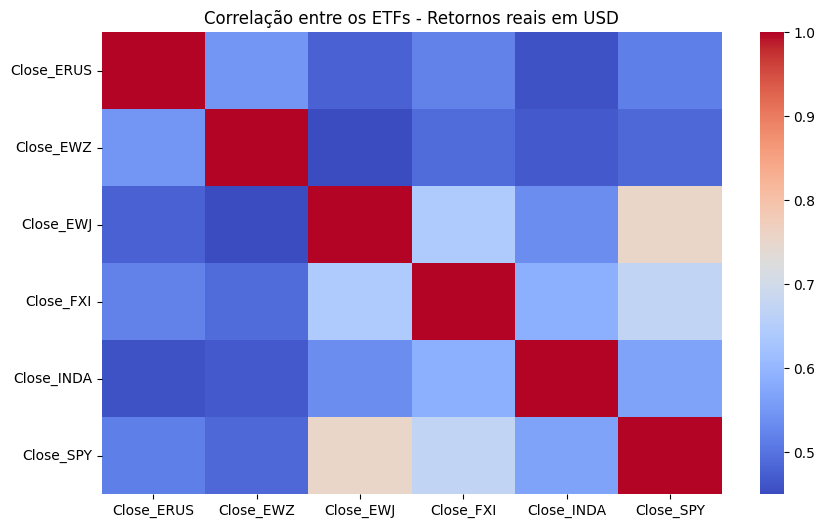

In [4]:
#Todas variaves - Heatmap
display(Return_percent_day)

plt.figure(figsize=(10, 6))
sns.heatmap(Return_percent_day.corr(), cmap='coolwarm')
plt.title('Correlação entre os ETFs - Retornos reais em USD')
plt.show()

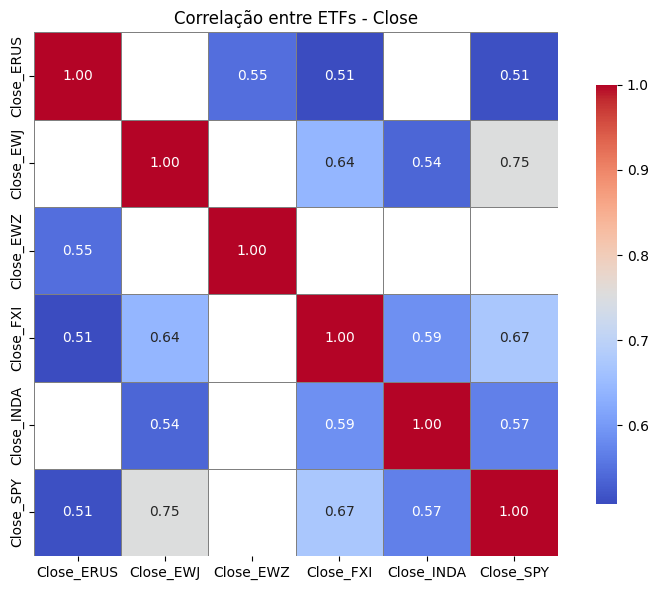

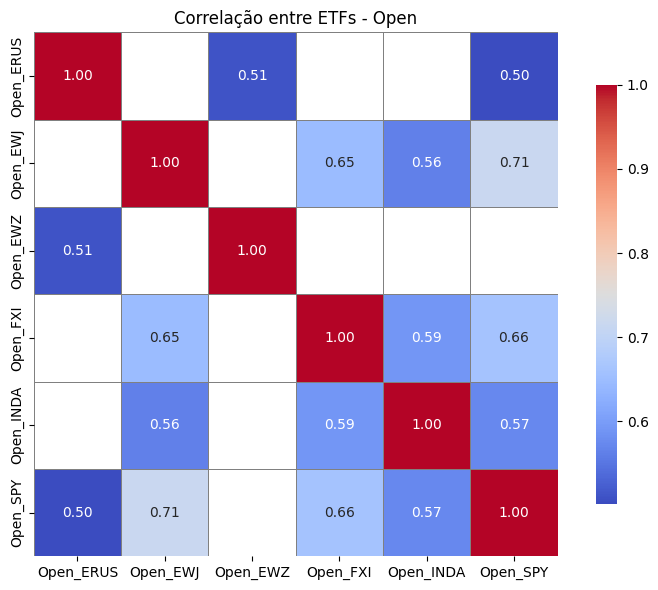

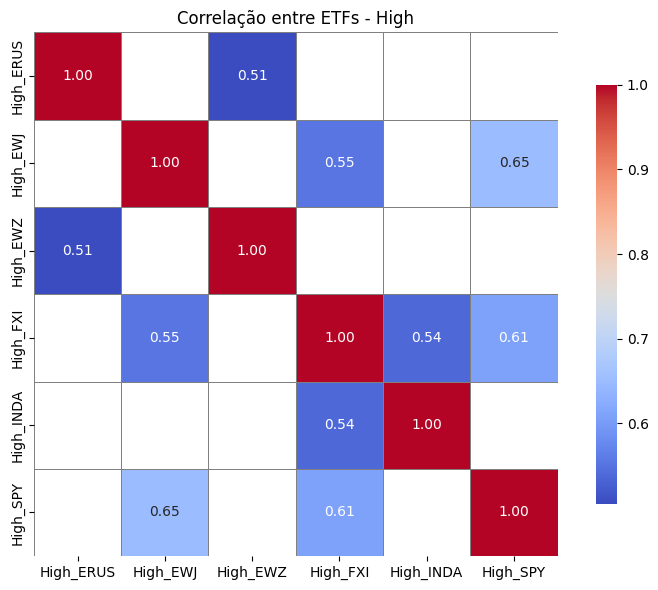

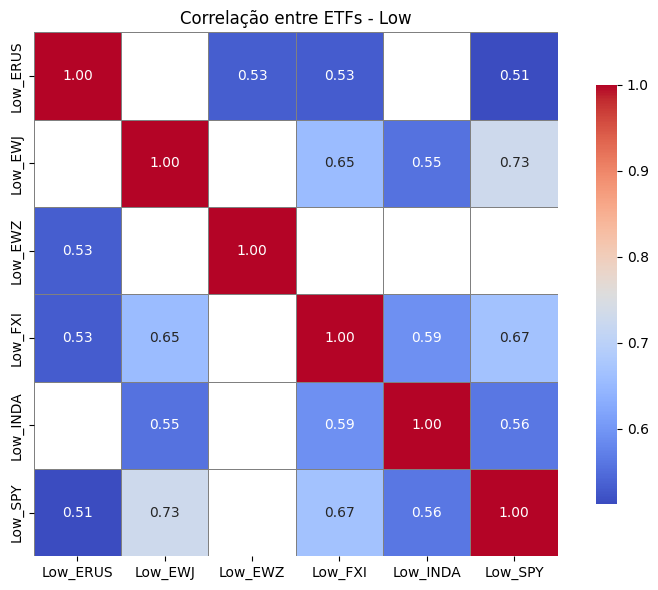

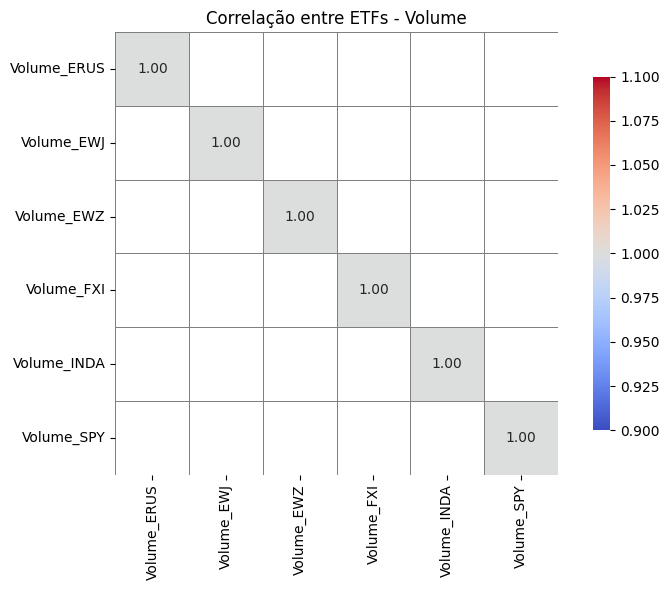

In [5]:
for tipo in Variaveis:
    subset = data.filter(like=tipo)
    returns = subset.pct_change().dropna()
    corr_matrix = returns.corr()
    mask = corr_matrix.abs() < 0.5
    plt.figure(figsize=(8, 6))

  
    #sns.heatmap(returns.corr(), annot=True, cmap='coolwarm') # Printa todas as correlações


#Tira correlações abaixo de 0.5
    sns.heatmap(corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=0.5,
    linecolor='gray',
    square=True,
    cbar_kws={"shrink": 0.8})
    plt.title(f'Correlação entre ETFs - {tipo}')
    plt.tight_layout()
    plt.show()

,Close_ERUS,Close_EWZ,Close_EWJ,Close_FXI,Close_INDA,Close_SPY
Date,,,,,,
2015-01-02,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2015-01-05,95.986034,96.578070,98.845477,99.640103,98.387633,98.194067
2015-01-06,95.811526,98.303165,97.246893,98.416532,95.393238,97.269164
2015-01-07,99.563695,100.961556,98.667841,101.007646,97.268842,98.481245
2015-01-08,106.020938,102.573531,99.911192,101.823415,99.868367,100.228782
...,...,...,...,...,...,...
2019-12-23,193.793052,149.660226,143.928495,117.721227,122.502555,172.551117
2019-12-24,194.897555,149.532008,143.350546,117.940027,122.052180,172.556489
2019-12-26,195.311763,152.832897,143.735836,119.116166,121.463232,173.475068


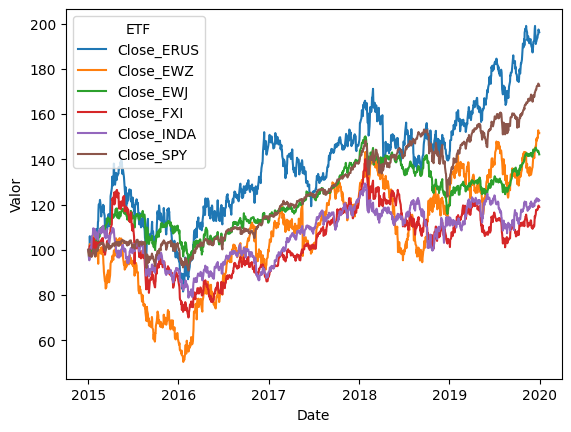

In [6]:
# Reenomeando para facilitação (Acredito que ajudará)
#data.rename(columns=lambda x: x.replace("Adj Close", "AdjClose"), inplace=True)

#Filtrar apenas fechamento
adj_close = data[['Close_ERUS', 'Close_EWZ' , 'Close_EWJ', 'Close_FXI', 'Close_INDA', 'Close_SPY']]

# Normalização para variações percentuais
normalized = adj_close/ adj_close.iloc[0] * 100

#Comparar o desempenho acumulado (matplto)
#normalized.plot(figsize=(12, 6), title='Desempenho acumulado dos ETFs (base 100)')

# Transforma os dados para formato "long" (necessário para seaborn)
normalized_long = normalized.reset_index().melt(id_vars='Date', var_name='ETF', value_name='Valor')

# Cria o gráfico com seaborn
sns.lineplot(data=normalized_long, x='Date', y='Valor', hue='ETF', palette='tab10')


display(normalized)

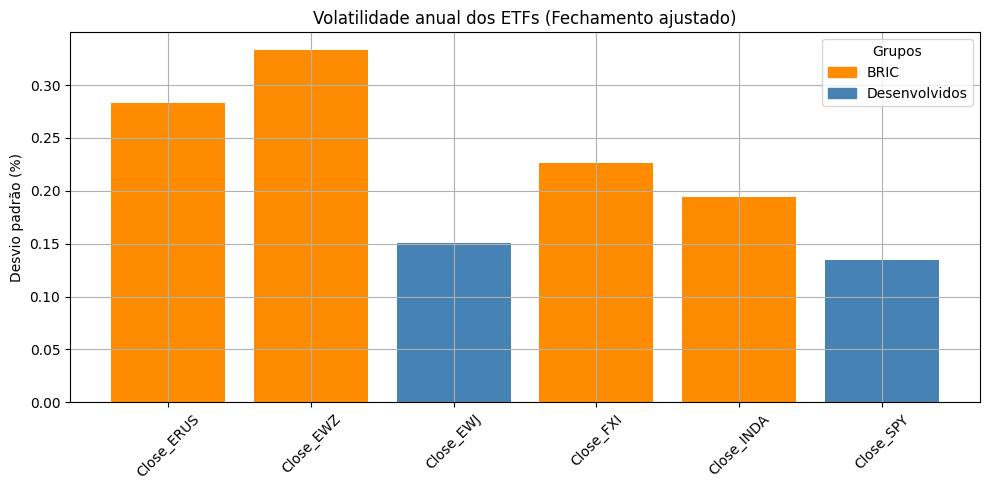

,Volume_ERUS,Volume_EWJ,Volume_EWZ,Volume_FXI,Volume_INDA,Volume_SPY
Date,,,,,,
2015-01-05,0.606790,0.205907,0.249643,0.256589,-0.340923,0.396545
2015-01-06,-0.621700,-0.056223,-0.045333,0.185311,0.884071,0.232967
2015-01-07,-0.107200,0.170991,-0.224899,-0.081265,-0.338789,-0.400689
2015-01-08,2.106166,-0.477983,-0.142840,-0.343447,-0.109808,0.174485
2015-01-09,-0.604660,1.175420,-0.325439,0.259338,-0.039097,0.077093
...,...,...,...,...,...,...
2019-12-23,-0.537724,-0.388492,-0.129727,-0.667067,0.102301,-0.639872
2019-12-24,-0.135800,-0.054542,-0.895835,-0.451597,-0.519512,-0.617475
2019-12-26,-0.483282,-0.046312,5.803085,1.233338,-0.123311,0.524973


Close_ERUS    0.283063
Close_EWZ     0.333143
Close_EWJ     0.150692
Close_FXI     0.226095
Close_INDA    0.193818
Close_SPY     0.134325
dtype: float64

In [7]:
returns_percent_close = adj_close.pct_change().dropna() # retornos percentuais dia - Fechamento

volatility = returns_percent_close.std() * np.sqrt(252)

# Grupos
bric = ['Close_EWZ', 'Close_ERUS', 'Close_FXI', 'Close_INDA']

desenvolvidos = ['Close_SPY', 'Close_EWJ']

# Cores
cores = []
for etf in volatility.index:
    if etf in bric:
        cores.append('darkorange')
    elif etf in desenvolvidos:
        cores.append('steelblue')
    else:
        cores.append('gray')



# Gráfico
plt.figure(figsize=(10, 5))
plt.bar(volatility.index, volatility.values, color=cores)
plt.title('Volatilidade anual dos ETFs (Fechamento ajustado)')
plt.ylabel('Desvio padrão (%)')
plt.grid(True)

# Legenda
legenda = [
    Patch(color='darkorange', label='BRIC'),
    Patch(color='steelblue', label='Desenvolvidos')
]
plt.legend(handles=legenda, title='Grupos')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

display(returns)
display (volatility) 

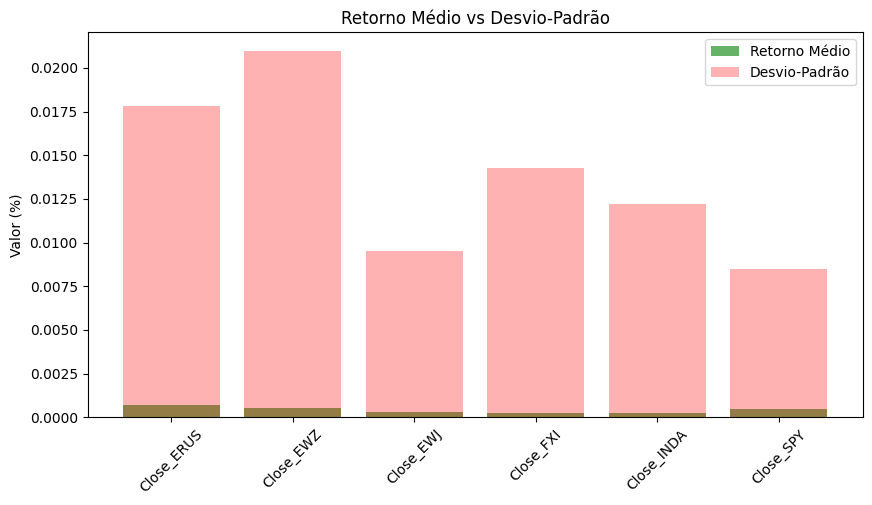

In [8]:
mean_return_close = returns_percent_close.mean()
std_dev_close = returns_percent_close.std()
coef_var_close = std_dev_close / mean_return_close

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(mean_return_close.index, mean_return_close, color='green', alpha=0.6, label='Retorno Médio')
ax.bar(std_dev_close.index, std_dev_close, color='red', alpha=0.3, label='Desvio-Padrão')
ax.set_ylabel('Valor (%)')
ax.set_title('Retorno Médio vs Desvio-Padrão')
ax.legend()
plt.xticks(rotation=45)
plt.show()

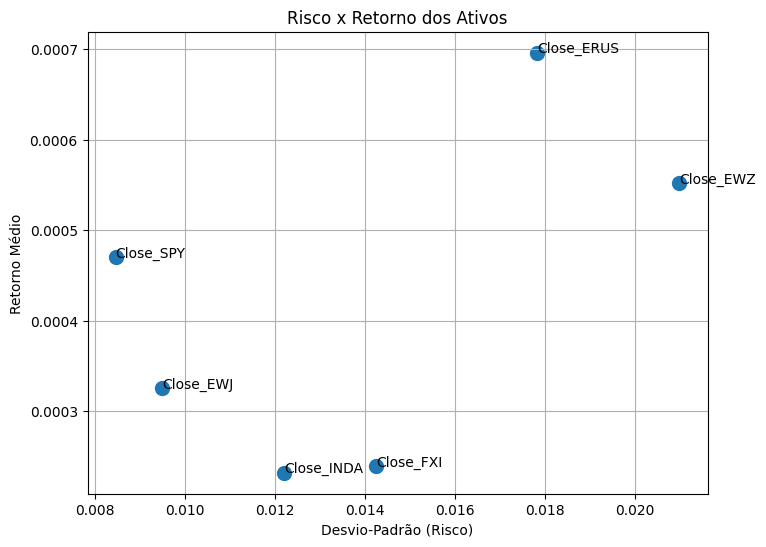

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(std_dev_close, mean_return_close, s=100)

for i in mean_return_close.index:
    plt.annotate(i, (std_dev_close[i], mean_return_close[i]))

plt.xlabel('Desvio-Padrão (Risco)')
plt.ylabel('Retorno Médio')
plt.title('Risco x Retorno dos Ativos')
plt.grid(True)
plt.show()

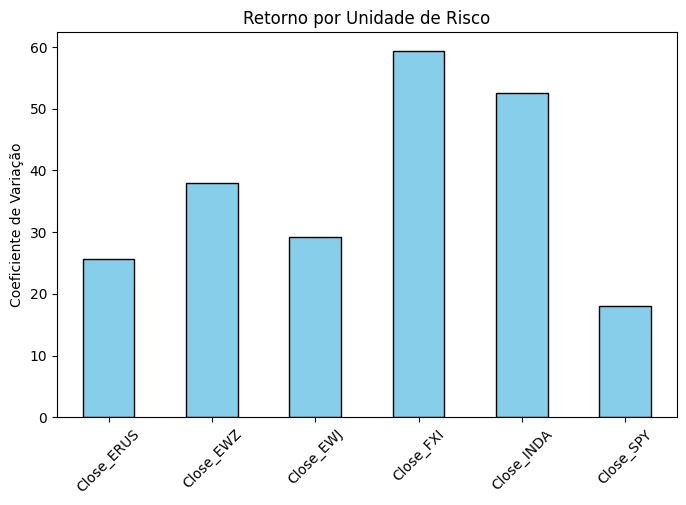

In [10]:
coef_var_close.plot(kind='bar', figsize=(8,5), color='skyblue', edgecolor='black')
plt.ylabel('Coeficiente de Variação')
plt.title('Retorno por Unidade de Risco')
plt.xticks(rotation=45)
plt.show()

ANALISE DAS CARTEIRAS SEGUINDO O METODOS DE ASSET LOCATION PELO ARTIGO KADIMA

1 - Equal-weighted (Mesma porcentagem de ativo na carteira)

2 - Vol-inverse (Quanto menor a volatilidade(risco) maior a presença desse ativo na carteira)

3 - Min-vol (Carteira com menor indice de volatilidade)

4 - Max-sharpe (Carteira com maior indice de Rentabiliade Esperada)

In [11]:
# Equal-weighted para carteira com todos os índices
nomes_ativos = ['EWZ', 'EWJ', 'ERUS', 'INDA', 'FXI', 'SPY']

pesos = np.ones(len(nomes_ativos)) / len(nomes_ativos)

retorno_esperado = np.dot(pesos, mean_return)
volatilidade = np.sqrt(np.dot(pesos.T, np.dot(coef_var, pesos)))

# Anualizando os valores
retorno_anual = retorno_esperado * 252
vol_anual = volatilidade * np.sqrt(252)

# Taxa livre de risco
taxa_livre_de_risco = 0.02  # 2% ao ano

# Sharpe Ratio
sharpe = (retorno_anual - taxa_livre_de_risco) / vol_anual

# Exibindo os resultados
print(f"Retorno anualizado: {retorno_anual}")
print(f"Volatilidade anualizada: {vol_anual}")
print(f"Sharpe Ratio: {sharpe}")

Retorno anualizado: 0.08490363839447959
Volatilidade anualizada: [49.20867452 49.20867452 49.20867452 49.20867452 49.20867452 49.20867452]
Sharpe Ratio: [0.00131895 0.00131895 0.00131895 0.00131895 0.00131895 0.00131895]


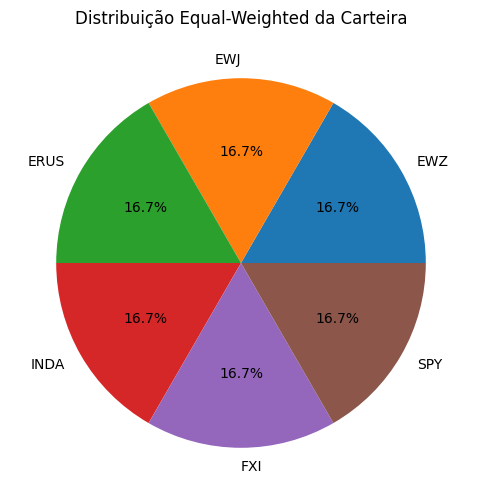

In [12]:
plt.figure(figsize=(8,6))
plt.pie(pesos, labels=tickers, autopct='%1.1f%%')
plt.title('Distribuição Equal-Weighted da Carteira')
plt.show()

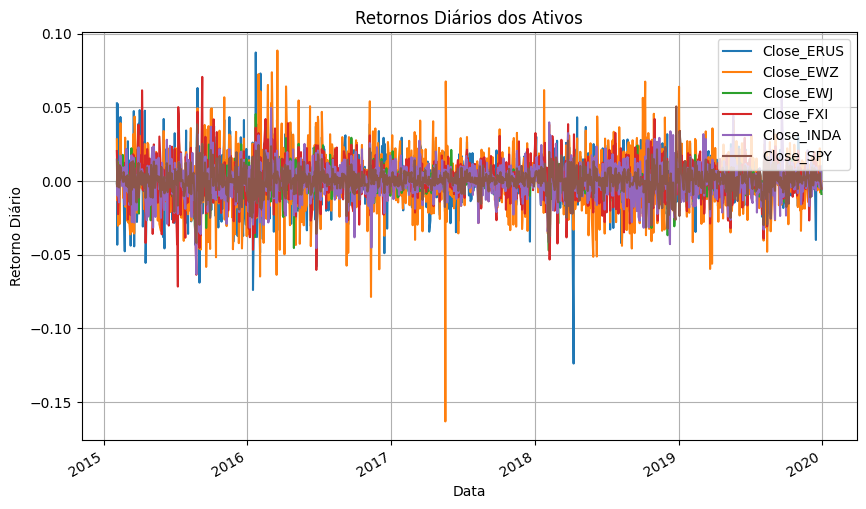

In [13]:
Return_percent_day.plot(figsize=(10,6))
plt.title('Retornos Diários dos Ativos')
plt.xlabel('Data')
plt.ylabel('Retorno Diário')
plt.grid(True)
plt.legend(loc='upper right')
plt.show()

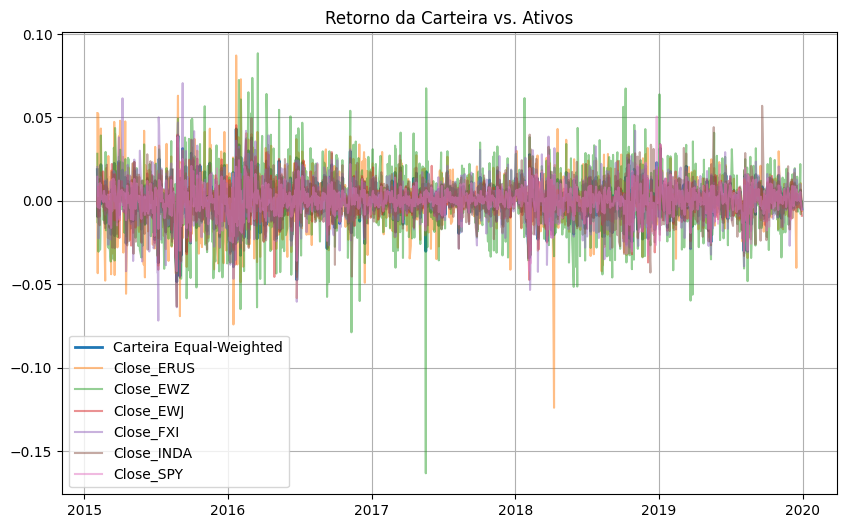

In [14]:
retorno_carteira = Return_percent_day.dot(pesos)
plt.figure(figsize=(10,6))
plt.plot(retorno_carteira, label='Carteira Equal-Weighted', linewidth=2)
for nomes_ativos in Return_percent_day.columns:
    plt.plot(Return_percent_day[nomes_ativos], alpha=0.5, label=nomes_ativos)
plt.title('Retorno da Carteira vs. Ativos')
plt.legend()
plt.grid(True)
plt.show()

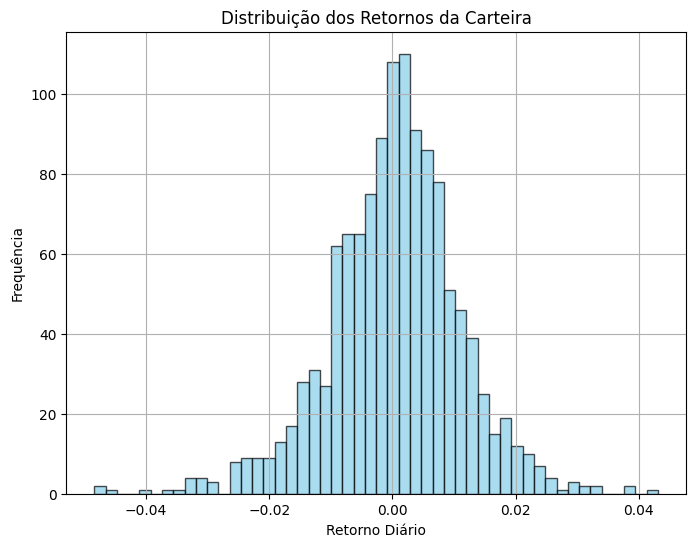

In [15]:
plt.figure(figsize=(8,6))
plt.hist(retorno_carteira, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição dos Retornos da Carteira')
plt.xlabel('Retorno Diário')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()

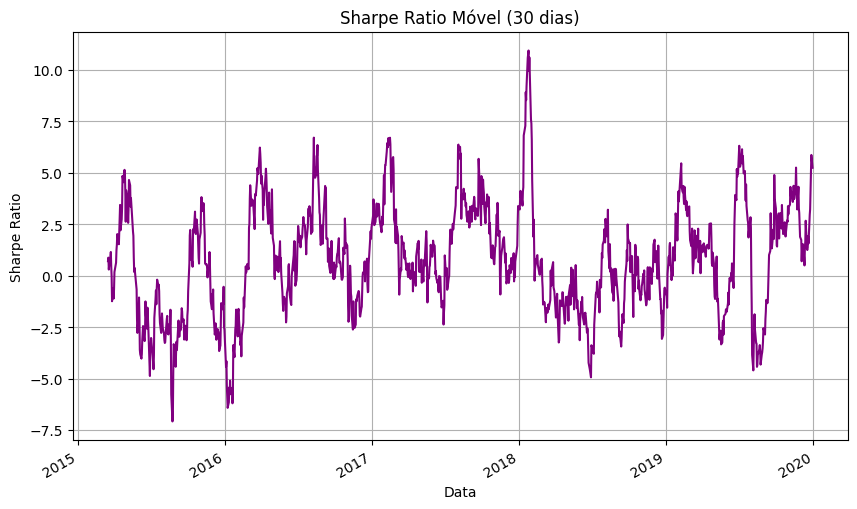

In [16]:
rolling_sharpe = (retorno_carteira.rolling(30).mean() / retorno_carteira.rolling(30).std()) * np.sqrt(252)
rolling_sharpe.plot(figsize=(10,6), color='purple')
plt.title('Sharpe Ratio Móvel (30 dias)')
plt.xlabel('Data')
plt.ylabel('Sharpe Ratio')
plt.grid(True)
plt.show()

2 METODO

-MIN VOL

In [17]:
df_returns = df_returns = pd.DataFrame(Return_percent_day, columns=['EWZ', 'EWJ', 'ERUS', 'INDA', 'FXI', 'SPY'])

vol_30d = df_returns.rolling(window=30).std()


inv_vol = 1 / vol_30d
weights = inv_vol.div(inv_vol.sum(axis=1), axis=0)  # Normaliza para somar 1]

print(df_returns.head)



<bound method NDFrame.head of             EWZ  EWJ  ERUS  INDA  FXI  SPY
Date                                      
2015-02-03  NaN  NaN   NaN   NaN  NaN  NaN
2015-02-04  NaN  NaN   NaN   NaN  NaN  NaN
2015-02-05  NaN  NaN   NaN   NaN  NaN  NaN
2015-02-06  NaN  NaN   NaN   NaN  NaN  NaN
2015-02-09  NaN  NaN   NaN   NaN  NaN  NaN
...         ...  ...   ...   ...  ...  ...
2019-12-23  NaN  NaN   NaN   NaN  NaN  NaN
2019-12-24  NaN  NaN   NaN   NaN  NaN  NaN
2019-12-26  NaN  NaN   NaN   NaN  NaN  NaN
2019-12-27  NaN  NaN   NaN   NaN  NaN  NaN
2019-12-30  NaN  NaN   NaN   NaN  NaN  NaN

[1236 rows x 6 columns]>
